## Credit Risk Classification

#### Import libraries

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re 

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

sns.set_style('ticks')
pd.set_option('display.max_columns', None)

%matplotlib inline

#### Import data

In [4]:
payment = pd.read_csv('./payment_data.csv', parse_dates=['update_date','report_date'])
customer = pd.read_csv('./customer_data.csv')

In [5]:
payment.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,2016-04-12,0.0,NaN,NaT
1,58995151,0,0,0,0,1,5,NaN,2016-04-12,588720.0,491100.0,NaT
2,58997200,0,0,0,0,2,5,NaN,2016-04-12,840000.0,700500.0,2016-04-22
3,54988608,0,0,0,0,3,10,37400.0,2016-03-12,8425.2,7520.0,2016-04-25
4,54987763,0,0,0,0,2,10,NaN,2016-03-12,15147.6,NaN,2016-04-26


In [6]:
# Check unique customer id in payment data
len(payment['id'].unique())

1125

In [7]:
customer.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [8]:
# Check unique customer id in customer data
len(customer['id'].unique())

1125

In [9]:
customer['label'].value_counts()

0    900
1    225
Name: label, dtype: int64

## Data Cleaning

In [10]:
# create a list of tuples to contain dataframe and name
dfs = [
    (payment , 'payment'),
    (customer , 'customer')
    ]

# print some basic information for each dataframe 
# number of rows and columns
# number of duplicated rows
# datatype and number of null values for each column in the dataframe

def basic_check(df, name):
    print(f"""-----------------------------------------------\n
{name} dataframe \n
Rows: {df.shape[0]}             Columns: {df.shape[1]}
Duplicated rows: {(df.duplicated(keep=False) == True).sum()}
Columns:
{pd.concat([pd.DataFrame(data=df.dtypes, columns=['data_type']),
         pd.DataFrame(data=df.isnull().sum(), columns=['num_nulls'])], axis=1)}
    \n""")
print("DATAFRAMES INFORMATION")    

# call function    
[basic_check(df, name) for (df,name) in dfs];

DATAFRAMES INFORMATION
-----------------------------------------------

payment dataframe 

Rows: 8250             Columns: 12
Duplicated rows: 176
Columns:
                      data_type  num_nulls
id                        int64          0
OVD_t1                    int64          0
OVD_t2                    int64          0
OVD_t3                    int64          0
OVD_sum                   int64          0
pay_normal                int64          0
prod_code                 int64          0
prod_limit              float64       6118
update_date      datetime64[ns]         26
new_balance             float64          0
highest_balance         float64        409
report_date      datetime64[ns]       1114
    

-----------------------------------------------

customer dataframe 

Rows: 1125             Columns: 13
Duplicated rows: 0
Columns:
       data_type  num_nulls
label      int64          0
id         int64          0
fea_1      int64          0
fea_2    float64        149
fea_3

In [11]:
# List duplicated rows in payment data
payment[payment.duplicated(keep=False)]

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
123,58995703,0,0,0,0,1,10,NaN,2016-04-21,253.2,711.0,NaT
124,58995703,0,0,0,0,1,10,NaN,2016-04-21,253.2,711.0,NaT
168,58992285,0,0,0,0,1,10,74800.0,2016-03-20,7870.8,7058.0,NaT
169,58992285,0,0,0,0,1,10,74800.0,2016-03-20,7870.8,7058.0,NaT
211,58996069,0,0,0,0,1,6,NaN,2016-02-03,12000.0,15500.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...
8233,58995478,0,0,0,0,9,15,NaN,NaT,0.0,NaN,NaT
8236,58995478,0,0,0,0,1,15,NaN,NaT,0.0,NaN,NaT
8245,58995478,0,0,0,0,9,15,NaN,NaT,0.0,NaN,NaT
8246,54992408,0,0,0,0,1,2,NaN,NaT,0.0,NaN,NaT


In [12]:
# Drop duplicated rows in payment data
payment.drop_duplicates(inplace=True, keep='first',ignore_index=True)

## Feature Engineering

In [13]:
# Create aggregated features from existing payment data, grouped by customer id
payment['OVD_t1_sum'] = payment.groupby('id')['OVD_t1'].transform('sum')
payment['OVD_t2_sum'] = payment.groupby('id')['OVD_t2'].transform('sum')
payment['OVD_t3_sum'] = payment.groupby('id')['OVD_t3'].transform('sum')
payment['OVD_sum_days'] = payment.groupby('id')['OVD_sum'].transform('sum')
payment['pay_normal_mean'] = payment.groupby('id')['pay_normal'].transform('mean')
payment['prod_limit_mean'] = payment.groupby('id')['prod_limit'].transform('mean')
payment['new_balance_sum'] = payment.groupby('id')['new_balance'].transform('sum')
payment['highest_balance_mean'] = payment.groupby('id')['highest_balance'].transform('mean')
payment['history_count'] = payment.groupby('id')['id'].transform('size')
payment['unique_prod_code_count'] = payment.groupby('id')['prod_code'].transform('nunique')
payment

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date,OVD_t1_sum,OVD_t2_sum,OVD_t3_sum,OVD_sum_days,pay_normal_mean,prod_limit_mean,new_balance_sum,highest_balance_mean,history_count,unique_prod_code_count
0,58987402,0,0,0,0,1,10,16500.0,2016-04-12,0.0,NaN,NaT,0,0,0,0,2.800000,64900.000000,79977.6,60294.000000,5,2
1,58995151,0,0,0,0,1,5,NaN,2016-04-12,588720.0,491100.0,NaT,7,2,41,8572,8.642857,NaN,852283.2,127634.142857,14,7
2,58997200,0,0,0,0,2,5,NaN,2016-04-12,840000.0,700500.0,2016-04-22,0,0,0,0,1.700000,NaN,7375030.8,709214.600000,10,6
3,54988608,0,0,0,0,3,10,37400.0,2016-03-12,8425.2,7520.0,2016-04-25,0,0,0,0,12.250000,44000.000000,178394.4,54589.000000,4,2
4,54987763,0,0,0,0,2,10,NaN,2016-03-12,15147.6,NaN,2016-04-26,1,1,0,69,14.300000,93316.666667,62964.0,21311.222222,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,58998715,0,0,0,0,1,2,NaN,NaT,154012.8,128844.0,2015-12-16,2,3,3,708,17.714286,33000.000000,5889372.0,479113.785714,14,4
8155,58998715,0,0,0,0,1,2,NaN,NaT,1448944.8,2415400.0,2015-11-22,2,3,3,708,17.714286,33000.000000,5889372.0,479113.785714,14,4
8156,58999145,0,0,0,0,14,12,NaN,NaT,0.0,126500.0,NaT,8,20,36,11790,11.666667,122650.000000,696344.4,101347.666667,24,5
8157,54988209,0,0,0,0,5,13,NaN,NaT,20654.4,33315.0,NaT,0,0,0,0,8.571429,NaN,47442.0,33890.428571,7,3


In [14]:
# Drop original columns from payment data after creating new aggregated payment features
payment = payment.drop(['OVD_t1','OVD_t2','OVD_t3','OVD_sum','pay_normal','prod_code','prod_limit','update_date',
                        'new_balance','highest_balance','report_date'], axis=1)

In [15]:
# Drop duplicated rows in payment data
payment.drop_duplicates(inplace=True, keep='first',ignore_index=True)

In [16]:
payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1125 non-null   int64  
 1   OVD_t1_sum              1125 non-null   int64  
 2   OVD_t2_sum              1125 non-null   int64  
 3   OVD_t3_sum              1125 non-null   int64  
 4   OVD_sum_days            1125 non-null   int64  
 5   pay_normal_mean         1125 non-null   float64
 6   prod_limit_mean         945 non-null    float64
 7   new_balance_sum         1125 non-null   float64
 8   highest_balance_mean    1125 non-null   float64
 9   history_count           1125 non-null   int64  
 10  unique_prod_code_count  1125 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 96.8 KB


In [17]:
# Merge payment and customer data
payment_customer = pd.merge(customer,payment, on = "id", how = "left")

In [18]:
payment_customer

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_sum,OVD_t2_sum,OVD_t3_sum,OVD_sum_days,pay_normal_mean,prod_limit_mean,new_balance_sum,highest_balance_mean,history_count,unique_prod_code_count
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,0,2,26,11906,8.500000,60500.000000,160449.6,91298.000000,4,2
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840,2,2,0,195,11.600000,69666.666667,30607.2,74837.000000,15,5
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000,0,0,0,0,10.666667,102300.000000,655072.8,118865.666667,6,3
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000,0,0,0,0,23.000000,92400.000000,16279.2,90449.500000,4,3
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141,0,0,0,0,21.444444,154733.333333,2343270.0,395634.333333,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,0,58988196,5,1289.0,1,173000.0,2,15,5,112,3,350702,200.000000,0,0,0,0,15.142857,129800.000000,2020755.6,331959.833333,7,3
1121,0,58987926,5,NaN,2,50000.0,2,15,5,108,4,450000,169.000000,0,0,0,0,11.083333,70950.000000,325861.2,66887.166667,12,6
1122,0,58995381,7,1220.0,3,76000.0,2,11,2,90,5,71002,1.000000,8,5,2,681,11.250000,NaN,632674.8,94077.125000,8,5
1123,0,58998054,4,1250.0,3,137000.0,2,8,5,90,5,72000,1.000000,1,0,0,1,25.125000,69575.000000,170590.8,127470.000000,8,4


In [19]:
payment_customer.isnull().sum()

label                       0
id                          0
fea_1                       0
fea_2                     149
fea_3                       0
fea_4                       0
fea_5                       0
fea_6                       0
fea_7                       0
fea_8                       0
fea_9                       0
fea_10                      0
fea_11                      0
OVD_t1_sum                  0
OVD_t2_sum                  0
OVD_t3_sum                  0
OVD_sum_days                0
pay_normal_mean             0
prod_limit_mean           180
new_balance_sum             0
highest_balance_mean        0
history_count               0
unique_prod_code_count      0
dtype: int64

## Exploratory Data Analysis

In [20]:
payment_customer.describe()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_t1_sum,OVD_t2_sum,OVD_t3_sum,OVD_sum_days,pay_normal_mean,prod_limit_mean,new_balance_sum,highest_balance_mean,history_count,unique_prod_code_count
count,1125.000000,1.125000e+03,1125.000000,976.000000,1125.000000,1.125000e+03,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,945.000000,1.125000e+03,1.125000e+03,1125.000000,1125.000000
mean,0.200000,5.783677e+07,5.482667,1283.911373,2.333333,1.208836e+05,1.928889,10.872000,4.832889,100.802667,4.195556,164618.495111,134.999004,1.786667,0.919111,2.696889,1369.286222,14.267558,81739.014488,7.701944e+05,1.678283e+05,7.252444,2.716444
std,0.400178,1.817150e+06,1.383338,51.764022,0.878773,8.844523e+04,0.257125,2.676437,2.971182,11.988955,0.855679,152520.488281,112.616798,4.682898,3.293966,11.834777,6789.436806,6.057498,48629.920240,5.803034e+06,1.185450e+06,5.906320,1.445494
min,0.000000,5.498235e+07,1.000000,1116.500000,1.000000,1.500000e+04,1.000000,3.000000,-1.000000,64.000000,1.000000,60000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4913.333333,-8.422800e+03,2.424000e+03,1.000000,1.000000
25%,0.000000,5.499050e+07,4.000000,1244.000000,1.000000,7.200000e+04,2.000000,8.000000,5.000000,90.000000,3.000000,60044.000000,1.000000,0.000000,0.000000,0.000000,0.000000,9.750000,47850.000000,4.158720e+04,3.797975e+04,3.000000,2.000000
50%,0.000000,5.898975e+07,5.000000,1281.500000,3.000000,1.020000e+05,2.000000,11.000000,5.000000,105.000000,4.000000,72000.000000,173.205081,0.000000,0.000000,0.000000,0.000000,14.000000,72380.000000,1.510860e+05,6.758325e+04,6.000000,2.000000
75%,0.000000,5.899799e+07,7.000000,1314.500000,3.000000,1.390000e+05,2.000000,11.000000,5.000000,111.000000,5.000000,151307.000000,202.484567,1.000000,0.000000,0.000000,37.000000,18.333333,107800.000000,5.388528e+05,1.311517e+05,10.000000,4.000000
max,1.000000,5.900624e+07,7.000000,1481.000000,3.000000,1.200000e+06,2.000000,16.000000,10.000000,115.000000,5.000000,650070.000000,707.106781,68.000000,46.000000,153.000000,81050.000000,36.000000,526900.000000,1.871367e+08,3.884660e+07,55.000000,9.000000


In [21]:
# create function for violin subplots
def subplot_violin(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/2)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize=(15, nrows*4)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.violinplot(x = dataframe.label, y = dataframe[column], width = 0.3, ax = ax[i],orient='v')
        ax[i].set_title(f'{column} distribution',fontsize=14)  
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel('Label', fontsize=12)
        ax[i].set_ylabel(column, fontsize=12)
    plt.tight_layout()

In [22]:
# Create list of numerical features
col_numerical = ['fea_2','fea_4','fea_8','fea_10','fea_11','OVD_t1_sum','OVD_t2_sum','OVD_t3_sum','OVD_sum_days',
                 'pay_normal_mean','new_balance_sum','highest_balance_mean',
                 'history_count','unique_prod_code_count','prod_limit_mean'
                ]

# Create list of categorical features
col_categorical = ['fea_1','fea_3','fea_5','fea_6','fea_7','fea_9']

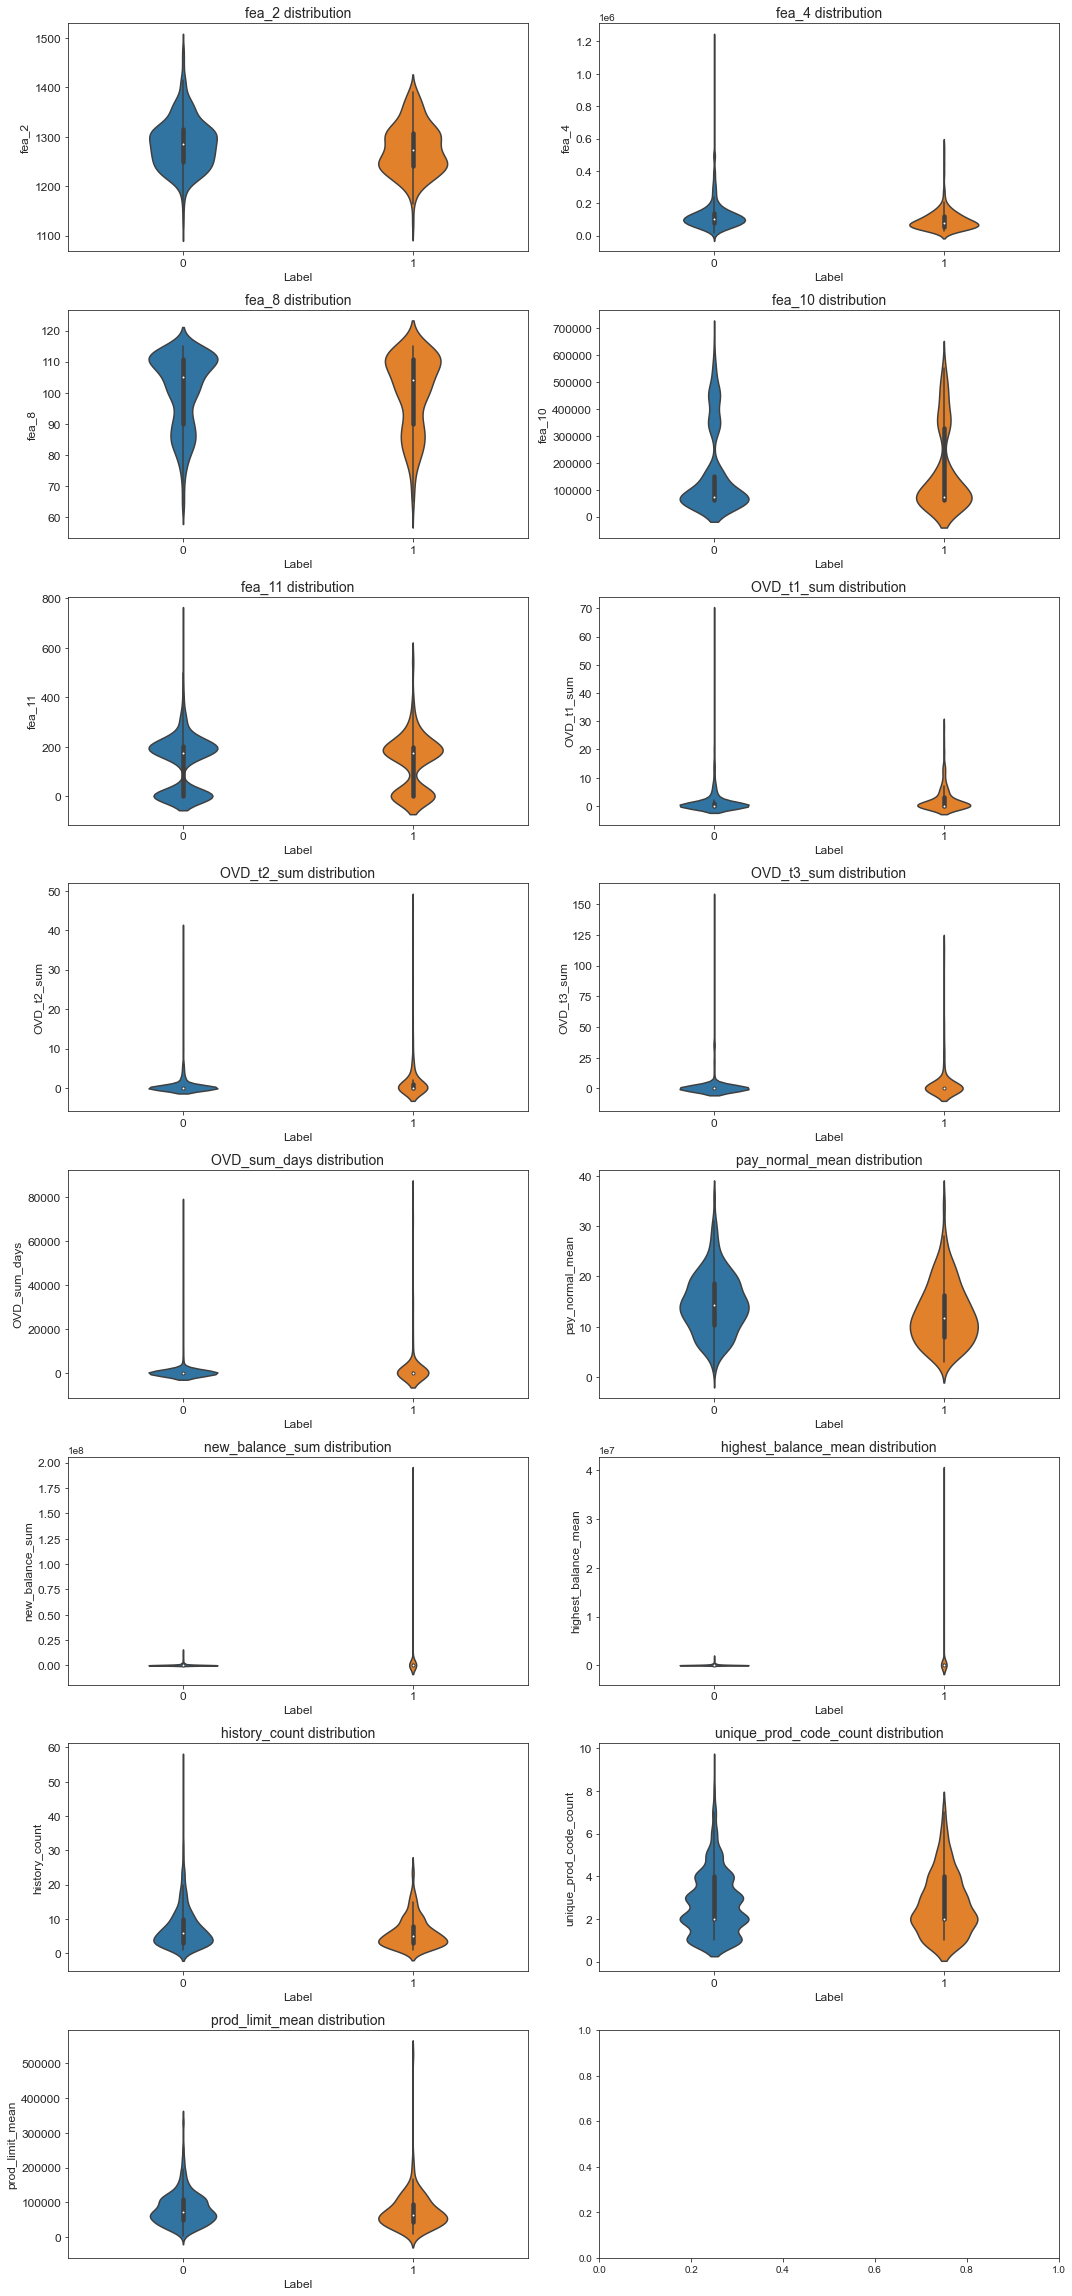

In [23]:
# Plot violin plots for numerical features
subplot_violin(payment_customer,col_numerical)

From the violin plots, we can observe that the customer's demographic features, `fea_2` and `fea_4` have some differences in the distribution between low risk and high risk customers. For `fea_2`, there is a bimodal distribution for high risk customers; for `fea_4`, the distribution of values is clustered at the lower end for high risk customers.

With regards to the card payment history features, we can clearly see that those high risk customers generally have higher overdue times and overdue days, lesser normal payment times, and higher current balance across various credit types which is not a surprise.

We can also observe that high risk customers generally have a lower card payment history counts and mean credit limit, probably due to more stringent bank approvals for various credit products given their high risk attributes. 

### Impute missing values

In [24]:
# Impute missing values using median of the label group, instead of dropping rows as important information might be lost due to small sample size.

payment_customer['fea_2'].fillna(payment_customer.groupby('label')['fea_2'].transform('median'), inplace=True)
payment_customer['prod_limit_mean'].fillna(payment_customer.groupby('label')['prod_limit_mean'].transform('median'), inplace=True)


### Numerical Feature Selection

#### ANOVA F-statistic

In [25]:
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(payment_customer[col_numerical], payment_customer['label'])

# convert to a dataframe
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': payment_customer[col_numerical].columns.values,
                                     'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,pay_normal_mean,19.846126,0.000009
1,fea_4,19.748457,0.000010
2,history_count,10.591904,0.001170
3,prod_limit_mean,9.513796,0.002089
4,fea_2,8.859508,0.002978
5,OVD_t2_sum,8.739597,0.003179
6,highest_balance_mean,6.058029,0.013993
7,new_balance_sum,5.392254,0.020404
8,OVD_sum_days,4.934119,0.026530
9,OVD_t1_sum,3.595785,0.058183


The ANOVA F-statistic for 15 numeric features shows a wide range of F values. Will keep the top 11 features with a low p-value.

#### Collinear features

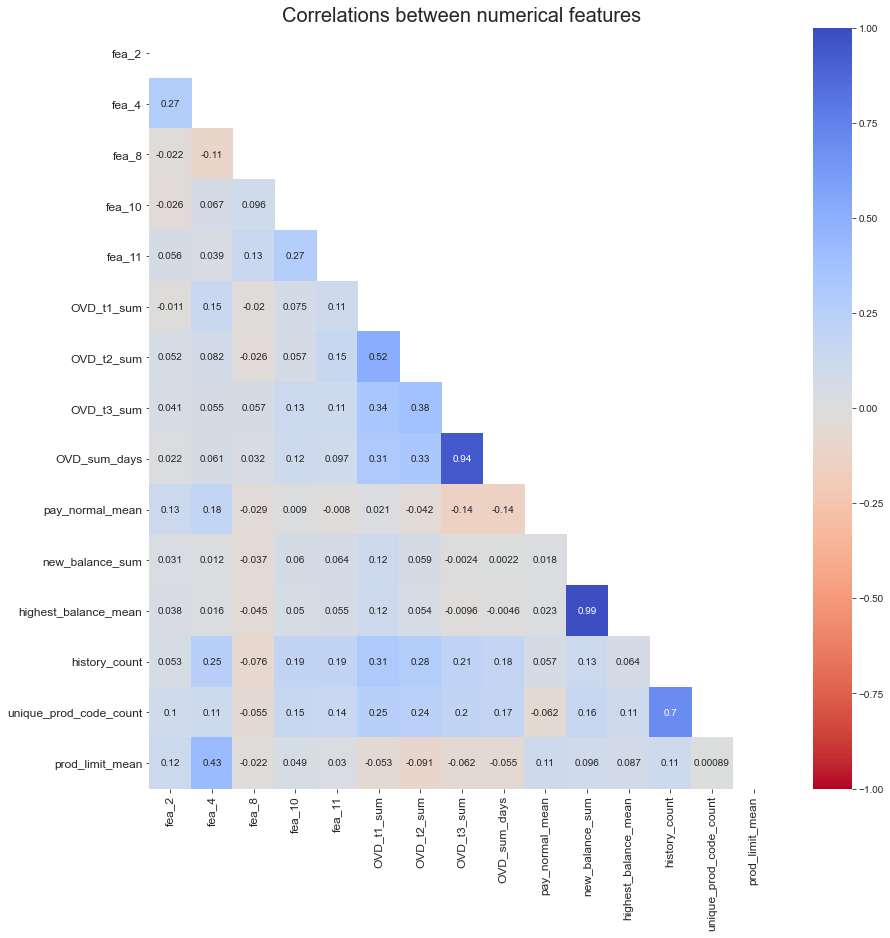

In [26]:
# Plot correlation heatmap to check for multicollinearity between numerical features

numerical_corr = payment_customer[col_numerical].corr() 

mask = np.zeros_like(numerical_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(14,14))
ax = sns.heatmap(numerical_corr, vmin=-1, vmax=1, mask=mask, annot = True, cmap = 'coolwarm_r')

ax.set_title('Correlations between numerical features', size = 20)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12, rotation=90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, rotation=0)

plt.show()

From the heatmap above, there are some features that are highly correlated with each other, with coefficient >0.9. Examples include:

- `OVD_sum_days` and `OVD_t3_sum`. Will drop `OVD_sum_days`. 
- `highest_balance_mean`and `new_balance_sum`. Will drop `highest_balance_mean`.

In [27]:
# Drop features with multi-collinearity (coefficient >0.9), and F-score < 1
payment_customer = payment_customer.drop(['OVD_sum_days', 'highest_balance_mean','fea_8','unique_prod_code_count',
                                        'fea_11','fea_10'], axis = 1) 

### Categorical Feature Selection

#### Chi-squared test for independence between categorical features

In [28]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each categorical feature column to calculate chi-statistic with the target variable (label)
for column in col_categorical:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(payment_customer['label'], payment_customer[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a dataframe
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,fea_3,0.021939
1,fea_6,0.273573
2,fea_1,0.361335
3,fea_5,0.663551
4,fea_9,0.785210
5,fea_7,0.816717


In [29]:
# Drop categorical features with p >0.05 (no relationship with target variable) 
payment_customer = payment_customer.drop(['fea_6', 'fea_1','fea_5','fea_9','fea_7'], axis = 1) 

In [30]:
payment_customer.head()

,label,id,fea_2,fea_3,fea_4,OVD_t1_sum,OVD_t2_sum,OVD_t3_sum,pay_normal_mean,prod_limit_mean,new_balance_sum,history_count
0,1,54982665,1245.5,3,77000.0,0,2,26,8.500000,60500.000000,160449.6,4
1,0,59004779,1277.0,1,113000.0,2,2,0,11.600000,69666.666667,30607.2,15
2,0,58990862,1298.0,1,110000.0,0,0,0,10.666667,102300.000000,655072.8,6
3,1,58995168,1335.5,1,151000.0,0,0,0,23.000000,92400.000000,16279.2,4
4,0,54987320,1284.5,2,59000.0,0,0,0,21.444444,154733.333333,2343270.0,9


## Modelling

### Pre-processing

In [31]:
X = payment_customer.drop(['label', 'id'], axis = 1)
y = payment_customer['label']

In [32]:
# Splitting into train, test datasets. Stratify target variable due to imbalanced data.
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42,stratify = y, test_size = 0.2)

In [33]:
# Standardise features to common scale
ss=  StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

### Model Selection Approach

We will use the ROC-AUC (Receiver Operating Characteristics - Area Under Curve) metric which tells how much a model is capable of distinguishing between classes, in our case detecting whether the customer is in high risk credit.

We will be evaluating between different classification models which include Logistic Regression, and ensemble models such as Random Forest, Gradient Boosting and XG Boost. 

To address the class imbalance where the high risk labels only make up 20% of the dataset, we will be using the Synthetic Minority Oversampling Technique (SMOTE) to oversample our minority class. The advantage of this technique is that it reduces chance of overfitting because it generates new synthetic examples from the minority class which are relatively close in feature space to existing examples from the minority class, instead of simply replicating the minority class. The class ratio will also be stratified when splitting the training and testing set to reduce potential sampling bias.

The different models are passed into a cross-validation pipeline to do a gridsearch on the best hyperparameters to optimise the AUC scores. 

### Modelling pipeline

In [34]:
# Models to train
model_dict = {
    'lr': LogisticRegression(),
    'rf':RandomForestClassifier(),
    'gbc':GradientBoostingClassifier(),
    'xgb': xgb.XGBClassifier()
}

In [35]:
# For ease of viewing results later on
model_name = {
    'lr':'Logistic Regression',
    'rf':'Random Forest',
    'gbc':'GradientBoost Classifier',
    'xgb': 'XGBoost Classifier'
}

In [36]:
# pipelines, choosing hyperparameters and gridsearching
def pipeline(model):
    pipe = Pipeline([('over', SMOTE(random_state=42)), (model, model_dict[model])])
    return pipe

def params(model):
    if model == 'lr':
        return {'lr__penalty':['l1','l2','enet'],
               'lr__C':np.linspace(0.01,10,10),
               'lr__random_state':[42]}

    elif model == 'rf':
        return {
            'rf__n_estimators':[200,300],
            'rf__max_depth':[3,4],
            'rf__min_samples_leaf':[3,5,8],
            'rf__min_samples_split':[3,5,8],
            'rf__random_state':[42]
        }

    elif model == 'gbc':
        return {
            'gbc__learning_rate':[0.1,0.3],
            'gbc__max_depth':[3,5],
            'gbc__min_samples_split':[2,3,4,5],
            'gbc__random_state':[42]
            
        }
    elif model == 'xgb':
        return {
            'xgb__eval_metric' : ['auc'],
            'xgb__subsample' : [0.5,0.8], 
            'xgb__colsample_bytree' : [0.5,0.8], 
            'xgb__learning_rate' : [0.1,0.3],
            'xgb__max_depth' : [3], 
            'xgb__scale_pos_weight': [8], 
            'xgb__n_estimators' : [300],
            'xgb__reg_alpha' : [0, 0.05],
            'xgb__reg_lambda' : [2,3],
            'xgb__gamma' : [0,0.1,0.3],
            'xgb__random_state':[42]
        }
    
def grid_search(model,X_train = X_train_ss,y_train = y_train,X_test = X_test_ss,y_test=y_test):
    pipe_params = params(model)
    pipe = pipeline(model)
    gs = GridSearchCV(pipe,param_grid = pipe_params,cv = 5, scoring = 'roc_auc', verbose=True, n_jobs=4)

    gs.fit(X_train,y_train)
    grid_search.train_score = gs.score(X_train,y_train)
    grid_search.test_score = gs.score(X_test,y_test)
    
    print(f'Results from: {model_name[model]}')
    print(f'-----------------------------------')
    print(f'Best Hyperparameters: {gs.best_params_}')
    print(f'Mean ROC AUC Score: {round(gs.best_score_,4)}')
    print(f'Train Score: {round(grid_search.train_score,4)}')
    print(f'Test Score: {round(grid_search.test_score,4)}')
    print(' ')

    print("recall score:", round(recall_score(y_test, gs.best_estimator_.predict(X_test)),4))  
    print("precision score:", round(precision_score(y_test, gs.best_estimator_.predict(X_test)),4))
    print("f1 score:", round(f1_score(y_test, gs.best_estimator_.predict(X_test)),4))
    
    # Create confusion matrix for evaluation on test data
    cm = confusion_matrix(y_test, gs.best_estimator_.predict(X_test))
    cm_df = pd.DataFrame(data = cm, columns = ['predict_low_risk','predict_high_risk'], index =['actual_low_risk','actual_high_risk'])
    return cm_df

In [719]:
grid_search('lr')

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  59 tasks      | elapsed:    5.7s


Results from: Logistic Regression
-----------------------------------
Best Hyperparameters: {'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__random_state': 42}
Mean ROC AUC Score: 0.655
Train Score: 0.6823
Test Score: 0.6832
 
recall score: 0.6889
precision score: 0.3039
f1 score: 0.4218


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    6.0s finished


,predict_low_risk,predict_high_risk
actual_low_risk,109,71
actual_high_risk,14,31


In [720]:
grid_search('rf')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:   22.5s finished


Results from: Random Forest
-----------------------------------
Best Hyperparameters: {'rf__max_depth': 4, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 3, 'rf__n_estimators': 300, 'rf__random_state': 42}
Mean ROC AUC Score: 0.7431
Train Score: 0.8561
Test Score: 0.779
 
recall score: 0.6667
precision score: 0.4615
f1 score: 0.5455


,predict_low_risk,predict_high_risk
actual_low_risk,145,35
actual_high_risk,15,30


In [721]:
grid_search('gbc')

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    6.5s finished


Results from: GradientBoost Classifier
-----------------------------------
Best Hyperparameters: {'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__min_samples_split': 3, 'gbc__random_state': 42}
Mean ROC AUC Score: 0.7658
Train Score: 0.9469
Test Score: 0.8075
 
recall score: 0.6
precision score: 0.551
f1 score: 0.5745


,predict_low_risk,predict_high_risk
actual_low_risk,158,22
actual_high_risk,18,27


In [722]:
grid_search('xgb')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   27.3s
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:   29.6s finished


Results from: XGBoost Classifier
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.5, 'xgb__eval_metric': 'auc', 'xgb__gamma': 0.3, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 300, 'xgb__random_state': 42, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 3, 'xgb__scale_pos_weight': 8, 'xgb__subsample': 0.8}
Mean ROC AUC Score: 0.7873
Train Score: 0.9999
Test Score: 0.7902
 
recall score: 0.6889
precision score: 0.4697
f1 score: 0.5586


,predict_low_risk,predict_high_risk
actual_low_risk,145,35
actual_high_risk,14,31


## Model Evaluation

The results for the different classifiers are summarised in the table below. The cross-validation AUC scores range from 0.655 to 0.787 for the different models, with the emsemble models outperforming the logistic regression model. 

Among the ensemble models, XG Boost has the highest CV score of 0.787. However, the XG Boost has a high degree of overfitting with a training score of close to 1.0, hence may not generalize well to unseen data. This is similar for the Gradient Boosting model.   

**Random Forest** was chosen as it has a lower variance between train and test scores, and was able to achieve a respectable recall of 0.667 on the test set, at expense of lower precision (higher false positives).

|Models |CV Score |Train Score |Test Score |Recall   |Precision|F1
|---	|---	  |---	       |---	            |---	    |---      |---
|Logistic Regression 	|0.655 |0.682          	|0.683   	|0.689   	|0.300     |0.422
|Random Forest 	        |0.743 |0.856          	|0.779   	|0.667   	|0.462     |0.546
|Gradient Boosting Tree |0.766 |0.947 	        |0.808   	|0.600   	|0.551     |0.575
|XG Boost 	            |0.787 |0.999          	|0.790   	|0.689   	|0.470     |0.559

### Performance of Selected Model

In [723]:
# Upsample training data

sm = SMOTE(random_state=42)
X_train_ss_upsample, y_train_upsample = sm.fit_resample(X_train_ss, y_train)

# Instantiate Random Forest model with best hyperparameters
rf = RandomForestClassifier(max_depth = 4, min_samples_leaf = 5, min_samples_split = 3, 
                            n_estimators = 300, random_state = 42)

# Fit model
rf.fit(X_train_ss_upsample, y_train_upsample)

RandomForestClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=3,
                       n_estimators=300, random_state=42)

In [724]:
# Generate dataframe on actual values versus predicted probabilities on test data
pred_proba = [i[1] for i in rf.predict_proba(X_test_ss)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.head()

,true_values,pred_probs
535,1,0.748525
819,0,0.290045
592,0,0.380198
867,0,0.484200
513,1,0.368486


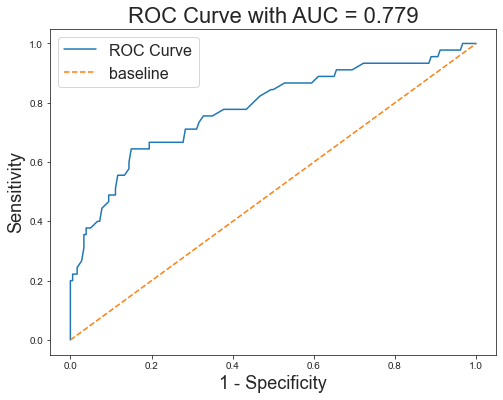

In [725]:
# Create figure for AUC ROC graph
plt.figure(figsize = (8,6))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

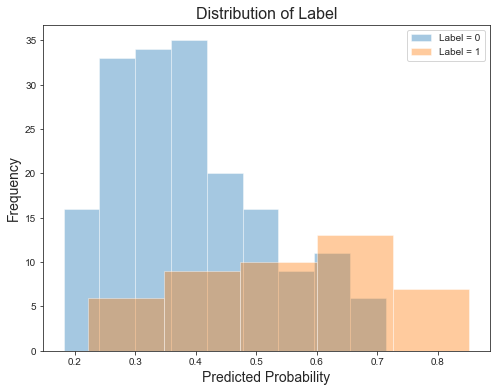

In [731]:
plt.figure(figsize = (8,6))

# Draw the density plot
sns.distplot(pred_df[pred_df['true_values'] == 0]['pred_probs'], hist = True, kde = False,
                 kde_kws = {'shade': True,'linewidth': 3},
                 label = 'Label = 0')
sns.distplot(pred_df[pred_df['true_values'] == 1]['pred_probs'], hist = True, kde = False,
                 kde_kws = {'shade': True,'linewidth': 3},
                 label = 'Label = 1')
# Plot formatting
plt.title('Distribution of Label', size=16)
plt.ylabel('Frequency', size=14)
plt.xlabel('Predicted Probability', size=14)
plt.legend(loc = 'upper right')

In [732]:
pred_df.groupby('true_values').describe()

pred_probs                                                    \
                 count      mean       std       min       25%       50%   
true_values                                                                
0                180.0  0.391836  0.122635  0.181737  0.294397  0.372943   
1                 45.0  0.558668  0.168197  0.221580  0.431036  0.579049   

                                 
                  75%       max  
true_values                      
0            0.466357  0.714320  
1            0.678639  0.852528

Threshold probability needs to be set at >0.2 to achieve 100% recall for the test set.

### Feature Importance

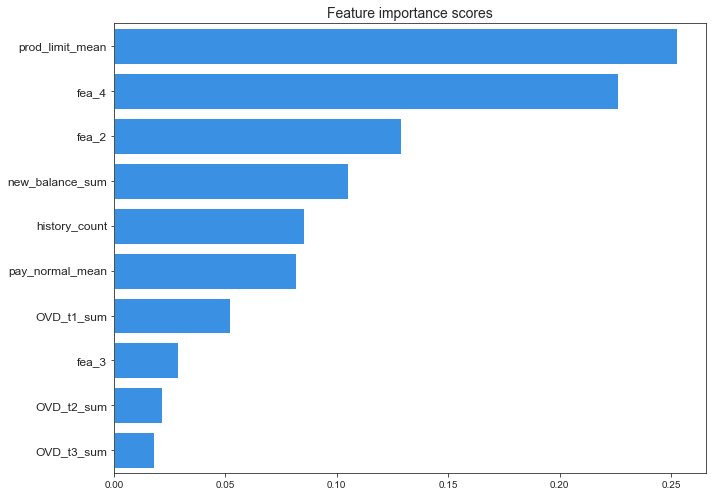

In [727]:
# Plot feature importance barchart
feature_impt = rf.feature_importances_

features = X_test.columns

feature_impt_df = pd.DataFrame(columns=['feature', 'importance'], data=list(zip(features, feature_impt))).sort_values('importance',ascending=False)

plt.figure(figsize = (10, 7))
sns.barplot(data = feature_impt_df, x = 'importance', y = 'feature', color = 'dodgerblue')
plt.title('Feature importance scores', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize = 12)
plt.tight_layout()

The feature importance is a measure of how each feature on average decreases the impurity of the split. From the feature importance scores, it can be seen that `prod limit_mean`, `fea_4`, `fea_2`, `new_balance_sum` and `history_count` are the top 5 important features for predicting the credit risk of a customer. 